In [1]:
%load_ext autoreload
%autoreload 2

# Export cells
#!python notebook2script.py Segmentation.ipynb

In [12]:
# Initial imports and device setting
import torch
from pathlib import Path
import re
import numpy as np
import scipy.ndimage as ndi
from PIL import Image
from torch.utils.data import dataloader as torch_dataloader
from functools import partial
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    dev_info = torch.cuda.get_device_properties(device)
    print(dev_info)
    print(torch.cuda.memory_allocated(device))
else:
    device = torch.device('cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)
2832304128


## Data

In [45]:
# Dataset storage
#export imagedataset.py
'''
Dataset storage class
'''

from pathlib import Path
from PIL import Image
import random
from torch.utils.data import dataset as torch_dataset
from torch.utils.data import dataloader as torch_dataloader
import re
from torchvision import transforms as torch_transforms
from torch import tensor, nn
from PIL import Image
import torch
import numpy as np

class ImageDataset(torch_dataset.Dataset):
    """Dataset storage class.
    
    Receives an input image and label directory and stores respective images. Images can be
    retrieved as follows:
    
    image_ds = ImageDataset(...)
    img, label = image_ds[0]
    
    or, in case weight_func is not None:
    
    img, label, weight = image_ds[0]

    Parameters
    ----------
    img_dir : string or pathlib path
        Directory containing the images to be read
    label_dir : string or pathlib path
        Directory containing the labels (segmentations) to be read
    name_2_label_map : function
        Function with signature name_2_label_map(img_filename) that translates image filenames into
        labels filenames. Receives an image filename and returns the filename of an image containing 
        the respective label
    filename_filter : list or function
        If list, contains names of the image files that should be kept, other images are ignored
        If function, has signature filename_filter(img_filename), receives an image filename and returns
        True if the image should be kept. The image is discarded otherwise
    img_opener : function
        Function with signature img_opener(img_path) for opening the images. Receives an image path 
        and returns a PIL.Image object. Images should be have uint8 type.
    label_opener: function
        Function with signature label_opener(label_path) for opening the labels. Receives an label path 
        and returns a PIL.Image object. The image should contain class indices and have uint8 type
    transforms : list of functions
        List of functions to be applied for image augmentation. Each function should have the signature
        transform(img, label, weight=None) and return a tuple (img, label) in case `weight_func` is None 
        or (img, label, weight) otherwise. The arguments of the first transform should be PIL.Image objects,
        while the return values of the last transform should be float32 torch.Tensor objects.
    weight_func : function
        Function for generating weights associated to each image. Those can be used for defining masks
        or, for instance, weighting the loss function. Must have signature 
        weight_func(pil_img, pil_label, img_path=None) and return a PIL.Image with F (float32) type
    """
    
    def __init__(self, img_dir, label_dir, name_2_label_map, filename_filter=None, img_opener=None,
                 label_opener=None, transforms=None, weight_func=None):

        if isinstance(img_dir, str):
            img_dir = Path(img_dir)
        if isinstance(label_dir, str):
            label_dir = Path(label_dir) 
        if isinstance(filename_filter, list):
            filename_filter = set(filename_filter)
        if transforms is None:
            transforms = []
        if img_opener is None:
            img_opener = Image.open
        if label_opener is None:
            label_opener = Image.open    
                   
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.name_2_label_map = name_2_label_map
        self.img_opener = img_opener
        self.label_opener = label_opener
        self.transforms = transforms
        self.weight_func = weight_func

        img_file_paths = []
        for img_file_path in img_dir.iterdir():
            img_filename = img_file_path.name
            if filename_filter is None:
                img_file_paths.append(img_file_path)
            elif isinstance(filename_filter, set):
                if img_file_path.stem in filename_filter: img_file_paths.append(img_file_path)       
            elif filename_filter(img_filename):
                img_file_paths.append(img_file_path)

        self.img_file_paths = img_file_paths

    def __getitem__(self, idx):
        '''Returns one item from the dataset. Will return an image and label if weight_func was
        not defined during class instantiation or an aditional weight image otherwise.'''
        
        img_file_path = self.img_file_paths[idx]
        
        img = self.img_opener(img_file_path)
        label_file_path = self.label_path_from_image_path(img_file_path)
        label = self.label_opener(label_file_path)
        
        if self.weight_func is not None:
            weight = self.weight_func(img, label, img_file_path)
            ret_transf = self.apply_transforms(img, label, weight)
        else:
            ret_transf = self.apply_transforms(img, label)

        return ret_transf
    
    def __len__(self):
        
        return len(self.img_file_paths)
              
    def label_path_from_image_path(self, img_file_path):
        '''Translates image path to label path.'''
        
        img_filename = img_file_path.name
        return self.label_dir/self.name_2_label_map(img_filename)    
    
    def check_dataset(self):
        '''Check if all images in the dataset can be read, and if the transformations
        can be successfully applied. It is usefull to call this function right after
        dataset creation.
        '''

        img_file_paths = self.img_file_paths

        shapes = []
        for img_idx, img_file_path in enumerate(img_file_paths):
            # Check if all data can be obtained
            try:
                ret_vals = self.__getitem__(img_idx)     # May return multiple items
            except Exception:    
                raise Exception(f'Cannot get image {img_file_paths[img_idx]} at index {img_idx}\n')

            for idx, ret_val in enumerate(ret_vals):
                # Check if data has the same shape
                if len(shapes)<(idx+1):
                    shapes.append(ret_val.shape)
                elif ret_val.shape!=shapes[idx]:
                    raise Exception(f"Data has different shape at index {img_idx}")            

        print('All images read')
                
    def split_train_val(self, valid_set=0.2):
        '''Split dataset into train and validation. Returns two new datasets.
        
        Parameters
        ----------
        valid_set : float or list
            If float, a fraction `valid_set` of the dataset will be used for validation,
            the rest will be used for training.
            If list, should containg the names of the files used for validation. The remaining
            images will be used for training.

        Returns
        -------
        train_dataset : ImageDataset
            Dataset to be used for training
        valid_dataset : ImageDataset
            Dataset to be used for validation     
        '''
        
        img_file_paths_train, img_file_paths_valid = self.split_train_val_paths(valid_set)
        # Hacky way to get parameters passed to __init__ during class construction
        init_pars_train = {}
        init_code = self.__init__.__code__
        for init_par in init_code.co_varnames[1:init_code.co_argcount]:
            if (init_par!='filename_filter'):
                try:
                    init_pars_train[init_par] = self.__getattribute__(init_par)
                except AttributeError:
                    raise AttributeError('Cannot split dataset, init parameter not registered in class')
        init_pars_valid = init_pars_train.copy()
        
        init_pars_train['filename_filter'] = img_file_paths_train
        init_pars_valid['filename_filter'] = img_file_paths_valid
        
        train_dataset = ImageDataset(**init_pars_train)
        valid_dataset = ImageDataset(**init_pars_valid)
        
        return train_dataset, valid_dataset
    
    def split_train_val_paths(self, valid_set=0.2):
        '''Generates image names to be used for spliting the dataset.
        
        Parameters
        ----------
        valid_set : float or list
            If float, a fraction `valid_set` of the dataset will be used for validation,
            the rest will be used for training.
            If list, should containg the names of the files used for validation. The remaining
            images will be used for training.

        Returns
        -------
        img_file_paths_train : list
            Images used for training
        img_file_paths_valid : list
            Images used for validation
        '''
        
        img_file_paths = self.img_file_paths
        num_images = len(img_file_paths)

        img_file_paths_train = []
        img_file_paths_valid = []
        
        if isinstance(valid_set, list):
            
            valid_set_set = set(valid_set)
            for file_idx, img_file_path in enumerate(img_file_paths):
                if img_file_path.stem in valid_set_set:
                    img_file_paths_valid.append(img_file_path)
                else:
                    img_file_paths_train.append(img_file_path)

            if (len(img_file_paths_train)+len(img_file_paths_valid))!=len(img_file_paths):
                print('Warning, some files in validation set not found')

        elif isinstance(valid_set, float):
            num_images_valid = int(num_images*valid_set)
            num_images_train = num_images - num_images_valid

            ind_all = list(range(num_images))
            random.shuffle(ind_all)
            ind_train = ind_all[0:num_images_train]
            ind_valid = ind_all[num_images_train:]

            img_file_paths_train = [img_file_paths[ind] for ind in ind_train]
            img_file_paths_valid = [img_file_paths[ind] for ind in ind_valid]
            
        img_file_paths_train = [file.stem for file in img_file_paths_train]
        img_file_paths_valid = [file.stem for file in img_file_paths_valid]
            
        return img_file_paths_train, img_file_paths_valid
        
    def as_tensor(self):
        '''Converts all images in the dataset to a single torch tensor.

        Returns
        -------
        tensors : torch.Tensor
            Tensor with dimensions (num images, num channels, height, width)
        '''
            
        img_file_paths = self.img_file_paths
        ret_vals = self.__getitem__(0)           # Open first image to get shape
        
        num_tensors = len(img_file_paths)
        tensors = [torch.zeros((num_tensors, *val.shape), dtype=val.dtype) for val in ret_vals]
        
        for file_idx, img_file_path in enumerate(img_file_paths):
            ret_vals = self.__getitem__(file_idx)
            for idx, ret_val in enumerate(ret_vals):
                tensors[idx][file_idx] = ret_val

        return tensors
        
    def apply_transforms(self, img, label, weight=None):
        '''Apply transformations stored in self.transforms
        
        Parameters
        ----------
        img, label, weight : Image-like
            Images to be processed

        Returns
        -------
        vals : Image-like
            Resulting images. Either (img, label) if weight is None or (img, label, weight) otherwise
        '''
        
        if weight is None:
            vals = [img, label]
        else:
            vals = [img, label, weight]
        for transform in self.transforms: 
                vals = transform(*vals)
        return vals

In [4]:
# Utility image functions
#export img_util.py
'''
Utilities for working with PIL, tensor, numpy and imgaug images
'''

def pil_img_info(img, print_repr=False):
    '''Returns the following information about a PIL image:
    The color mode (RGB, L, F, etc)
    Width
    Height
    Number of channels
    Intensity range (min, max)
    Additional info such as compression...
    
    Parameters
    ----------
    img : PIL.Image
        PIL image
    print_repr : bool
        If False, only returns a string with the image information. If True,
        also prints the information
        
    Returns
    -------
    info_str : string
        Information about the image
    '''
    
    if isinstance(img, Image.Image):
        info_str = f'''
        Image information:
        Mode:{img.mode}
        Width:{img.width}
        Height:{img.height}
        Num channels:{len(img.getbands())}
        Intensity range: {img.getextrema()}
        Additional info: {img.info}
        '''
    else:
        info_str = 'Not a PIL image'
        
    if print_repr:   
        print(info_str)
        
    return info_str

def tensor_info(tensor, print_repr=False):
    '''Returns the following information about a torch tensor:
    Shape
    Type
    
    Parameters
    ----------
    tensor : torch.Tensor
        Torch tensor
    print_repr : bool
        If False, only returns a string with the tensor information. If True,
        also prints the information
        
    Returns
    -------
    info_str : string
        Information about the tensor
    '''    
    
    if isinstance(tensor, torch.Tensor):
        info_str = f'''
        Tensor information:
        Shape:{tensor.shape}
        Type:{tensor.dtype}
        '''
    else:
        info_str = 'Not a tensor'
        
    if print_repr:   
        print(info_str)
        
    return info_str

def show(pil_img, binary=False):
    '''Show PIL image in a Jupyter notebook
    
    Parameters
    ----------
    pil_img : PIL.Image
        PIL image
    binary : bool
        If True, the image should be treated as binary. That is, the range
        [0, 1] is shown as [0, 255]
        
    Returns
    -------
    None
    '''    
    
    if binary:
        palette = [  0,     0,   0,    # RGB value for color 0
                   255,   255, 255]    # RGB value for color 1
        pil_img = pil_img.copy()
        pil_img.putpalette(palette)
    
    display(pil_img)
    
def pil_img_opener(img_file_path, channel=None, convert_gray=False, is_label=False, print_info=False):
    '''Opens a PIL image
    
    Parameters
    ----------
    img_file_path : string
        Path to the image
    channel : int
        Image channel to return. If None, returns all channels
    convert_gray : bool
        If True, image is converted to grayscale with single channel
    is_label : bool
        If True, image is treated as binary and intensities are coded as class indices.
        For instance, if the image contains the intensity values {0, 255}, they will be onverted
        to {0, 1}.
    print_info :  bool
        If True, image information is printed when opening the image.
        
    Returns
    -------
    img : PIL.Image
        The PIL image
    '''
    
    img = Image.open(img_file_path)
    if print_info: print(pil_img_info(img))
    
    if channel is not None: img = img.getchannel(channel)
    if convert_gray: img = img.convert('L')
    if is_label: 
        # Map intensity values to indices 0, 1, 2,...
        colors = [t[1] for t in img.getcolors()]
        lut = [0]*256
        for i, c in enumerate(colors):
            lut[c]=i 
        img = img.point(lut)       
        
    return img

In [5]:
# Transformations and data augmentation
#export transforms.py
'''
Image transformation routines
'''

import imgaug as ia

def to_tensor(img, is_label=False):
    '''Transform PIL.Image or numpy array to a tensor. Most of the
    function was taken from torchvision.transforms.functional.to_tensor.
    
    Note 1: Intensities are reescaled to [0, 1] if is_label is False and `img`
    is of type uint8. Use is_label=True if you do not want to reescale image 
    (even if it is not a label).
    
    Note 2: The image is expected to have size (height, width) or (height, width, channels).
    Returns image with size (channels, height, width).
    
    Parameters
    ----------
    img : PIL.Image or np.ndarray
        The input image
    is_label : bool
        If True, images is not reescaled
        
    Returns
    -------
    img : torch.Tensor
        The output image as a tensor
    '''

    if isinstance(img, np.ndarray):
        # handle numpy array
        if img.ndim == 2:
            img = img[:, :, None]

        img = torch.from_numpy(img.transpose((2, 0, 1)))
        # backward compatibility
        if isinstance(img, torch.ByteTensor) and not is_label:
            return img.float().div(255)
        else:
            return img

    # handle PIL Image
    if img.mode == 'I':
        img = torch.from_numpy(np.array(img, np.int32, copy=False))
    elif img.mode == 'I;16':
        img = torch.from_numpy(np.array(img, np.int16, copy=False))
    elif img.mode == 'F':
        img = torch.from_numpy(np.array(img, np.float32, copy=False))
    elif img.mode == '1':
        img = 255 * torch.from_numpy(np.array(img, np.uint8, copy=False))
    else:
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    # PIL image mode: L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK
    if img.mode == 'YCbCr':
        nchannel = 3
    elif img.mode == 'I;16':
        nchannel = 1
    else:
        nchannel = len(img.mode)
    img = img.view(img.size[1], img.size[0], nchannel)
    # put it from HWC to CHW format
    img = img.transpose(0, 1).transpose(0, 2).contiguous()
    if isinstance(img, torch.ByteTensor) and not is_label:
        return img.float().div(255)
    else:
        return img

def tensor_2_pil(tensor):
    '''Transform torch.Tensor to a PIL image.
    
    Note: Intensities are reescaled to [0, 255] if tensor is of type float. Values
    are not changed if the tensor is of type int.
    
    Parameters
    ----------
    tensor : torch.Tensor
        The input tensor
        
    Returns
    -------
    PIL.Image
        The output PIL image
    '''

    return torch_transforms.ToPILImage()(tensor)


def pil_to_imgaug(img, label=None, weight=None):
    '''Transform PIL images to corresponding objects of the imgaug (image augmentation)
    module.
    
    Parameters
    ----------
    img : PIL.Image
        PIL image, only tested for uint8 type
    label : PIL.Image
        Label, must contain integer values. Converted to a imgaug.SegmentationMapsOnImage object
    weight : PIL.Image
        Weight, converted to a imgaug.HeatmapsOnImage object
        
    Returns
    -------
    ret_vals : list
        List containing imgaug images corresponding to the `img`, `label` and `weight` inputs
    '''    

    img_shape = img.size[::-1]
    ret_vals = [np.array(img)]
    if label is not None:
        segmap = ia.SegmentationMapsOnImage(np.array(label), img_shape)
        ret_vals.append(segmap)
    if weight is not None:
        heatmap = ia.HeatmapsOnImage(np.array(weight), img_shape)
        ret_vals.append(heatmap)
        
    return ret_vals

def imgaug_to_tensor(img=None, label=None, weight=None):
    '''Transform imgaug (image augmentation) images to torch tensors.
    
    Parameters
    ----------
    img : np.ndarray
        Image to be transformed
    label : imageaug.SegmentationMapsOnImage
        Label image
    weight : imageaug.HeatmapsOnImage
        Weight image
        
    Returns
    -------
    ret_vals : list
        torch tensors corresponding to the `img`, `label` and `weight` inputs
    '''  
    
    ret_vals = []
    if img is not None:
        ret_vals.append(to_tensor(img))
    if label is not None:
        ret_vals.append(to_tensor(label.get_arr(), True))
    if weight is not None:
        ret_vals.append(to_tensor(weight.get_arr()))
    
    return ret_vals

def translate_imagaug_seq(imgaug_seq):
    '''Closure for translating arguments 'image', 'segmentation_maps' and 'heatmaps' of 
    imgaug functions to 'img', 'label' and 'weight'
    
    Parameters
    ----------
    imgaug_seq : function or class
        imgaug function or class to be translated. Usually, it is an imgaug.Sequential
        class
        
    Returns
    -------
    transf_imgaug_seq : function
        New function with translated arguments
    '''  
    
    def transf_imgaug_seq(img, label=None, weight=None, **kwargs):
        return imgaug_seq(image=img, segmentation_maps=label, heatmaps=weight, **kwargs)
    
    return transf_imgaug_seq
        
def clahe(pil_img, clip_limit=2.0, tile_shape=(8, 8)):
    '''Contrast Limited Adaptive Histogram Equalization.
    
    Parameters
    ----------
    pil_img : PIL.Image
        Image to be transformed
    clip_limit : float
        Threshold value for contrast limiting
    tile_shape : 2-tuple
        Tuple setting the tile size for the method
        
    Returns
    -------
    out_pil_img : PIL.Image
        Output image
    '''  
    
    np_img = np.array(pil_img).astype(np.uint8)
    enhancer = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_shape)
    if np_img.ndim == 2:
        np_img = enhancer.apply(np_img)
    elif np_img.ndim == 3:
        np_img[:, :, 0] = enhancer.apply(np_img[:, :, 0])
        np_img[:, :, 1] = enhancer.apply(np_img[:, :, 1])
        np_img[:, :, 2] = enhancer.apply(np_img[:, :, 2])
        
    out_pil_img = Image.fromarray(np_img)
    return out_pil_img

In [3]:
# Data management functions for DRIVE
'''
Used in the ImageDataset class for storing the DRIVE images
'''

def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename

def name_2_mask_map(img_filename):
    '''Maps image names to mask names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    mask_filename : string
        Filename of a mask
    '''    
        
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    mask_filename = index + '_mask.gif'

    return mask_filename   

def filename_filter(img_filename, test=False):
    '''Filter DRIVE images for getting only training or test images.
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
    test : bool
        If True, the function checks if the image should be in the test set
    
    Returns
    -------
    bool
        If `test` is False, returns True if the image should be in the training set and
        False if it should be in the test set. Return values are reversed if `test` is True
    '''
    
    if test:
        return 'test' in img_filename
    else:
        return 'test' not in img_filename
    
def weight_func_small_vess(pil_img, pil_label, img_path=None, mask_threshold=0, opening_size=2,
                           background_weight=1, vessel_weight=1, small_vessel_weight=1):
    '''Weight function for DRIVE images. Thin vessels are detected an can be weighted differently than
    large vessels.
    
    Thin vessels are detected by applying a binary opening to the label image and doing a logical xor 
    between the label and opened images.
    
    Parameters
    ----------
    pil_img : PIL.Image
        Image to be weighted
    pil_label : PIL.Image
        Label of the image to be weighted
    img_path : string
        Path to a weighted image saved on disk. Defined for compatibility with ImageDataset
    mask_threshold : int
        Pixels having intensity smaller than `mask_threshold` will have weight 0
    opening_size : int
        Number of opening operations for detecting thin vessels
    background_weight : float
        Pixels having intensity larger than `mask_threshold` and set as background in `pil_label` 
        will have this weight
    vessel_weight : float
        Pixels set as vessel in `pil_label` (having value 1) and not belonging to thin 
        vessels will have this weight
    small_vessel_weight : float
        Pixels set as vessel in `pil_label` (having value 1) and belonging to thin 
        vessels will have this weight
        
    Returns
    -------
    out_pil_img : PIL.Image
        Output image
    '''      
     
    np_img = np.array(pil_img).max(axis=2)
    roi_img = np_img>=mask_threshold
    
    np_label = np.array(pil_label).astype(np.uint8)
    label_open = ndi.binary_opening(np_label, iterations=opening_size)
    label_xor = np.logical_xor(np_label, label_open)

    weight = np.zeros(np_label.shape)
    weight[roi_img==1] = background_weight
    weight[np_label==1] = vessel_weight
    weight[label_xor==1] = small_vessel_weight
    weight = weight/np.mean(weight)
    pil_weight = Image.fromarray(weight)
    
    return pil_weight

## Models

In [7]:
# U-Net simple

import torch
import torch.nn.functional as F
from torch import nn

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, middle_channel, out_channels, kernel_size=3, p=1):
        super(DoubleConvolution, self).__init__()
        layers = [
            nn.Conv2d(in_channels, middle_channel, kernel_size=kernel_size, padding=p),
            nn.BatchNorm2d(middle_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channel, out_channels, kernel_size=kernel_size, padding=p),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        self.dconv = nn.Sequential(*layers)

    def forward(self, x):
        return self.dconv(x)

class UNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(UNet, self).__init__()

        reduce_by = 1

        self.l1_ = DoubleConvolution(num_channels, 64//reduce_by, 64//reduce_by)
        self.a1_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l2_ = DoubleConvolution(64//reduce_by, 128//reduce_by, 128//reduce_by)
        self.a2_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l3_ = DoubleConvolution(128//reduce_by, 256//reduce_by, 256//reduce_by)
        self.a3_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l4_ = DoubleConvolution(256//reduce_by, 512//reduce_by, 512//reduce_by)
        self.a4_dwn = nn.MaxPool2d(kernel_size=2, stride=2)

        self.l_mid = DoubleConvolution(512//reduce_by, 1024//reduce_by, 1024//reduce_by)   
        
        self.a_mid_up = nn.ConvTranspose2d(1024//reduce_by, 512//reduce_by, kernel_size=2, stride=2)
        self._l4 = DoubleConvolution(1024//reduce_by, 512//reduce_by, 512//reduce_by)

        self.a4_up = nn.ConvTranspose2d(512//reduce_by, 256//reduce_by, kernel_size=2, stride=2)
        self._l3 = DoubleConvolution(512//reduce_by, 256//reduce_by, 256//reduce_by)

        self.a3_up = nn.ConvTranspose2d(256//reduce_by, 128//reduce_by, kernel_size=2, stride=2)
        self._l2 = DoubleConvolution(256//reduce_by, 128//reduce_by, 128//reduce_by)

        self.a2_up = nn.ConvTranspose2d(128//reduce_by, 64//reduce_by, kernel_size=2, stride=2)
        self._l1 = DoubleConvolution(128//reduce_by, 64//reduce_by, 64//reduce_by)

        self.final = nn.Conv2d(64//reduce_by, num_classes, kernel_size=1)
        self.reset_parameters()

    def forward(self, x): 
        
        a1_ = self.l1_(x)
        a1_dwn = self.a1_dwn(a1_)

        a2_ = self.l2_(a1_dwn)
        a2_dwn = self.a2_dwn(a2_)

        a3_ = self.l3_(a2_dwn)
        a3_dwn = self.a3_dwn(a3_)

        a4_ = self.l4_(a3_dwn)
        # a4_ = F.dropout(a4_, p=0.2)
        a4_dwn = self.a4_dwn(a4_)

        a_mid = self.l_mid(a4_dwn)                      
        
        a_mid_up = self.a_mid_up(a_mid)                              
        _a4 = self._l4(UNet.match_and_concat(a4_, a_mid_up))      
        # _a4 = F.dropout(_a4, p=0.2)

        a4_up = self.a4_up(_a4)                                
        _a3 = self._l3(UNet.match_and_concat(a3_, a4_up))      

        a3_up = self.a3_up(_a3)                                
        _a2 = self._l2(UNet.match_and_concat(a2_, a3_up))      
        # _a2 = F.dropout(_a2, p=0.2)

        a2_up = self.a2_up(_a2)                                
        _a1 = self._l1(UNet.match_and_concat(a1_, a2_up))     

        final = self.final(_a1)
        return F.log_softmax(final, 1)

    @staticmethod
    def match_and_concat(bypass, upsampled, crop=True):
        
        if crop:
            c_h = (bypass.shape[2] - upsampled.shape[2])
            c_w = (bypass.shape[3] - upsampled.shape[3])
            if c_h%2==0:
                c_hu = c_hd = c_h//2
            else:
                c_hu = c_h//2
                c_hd = c_h//2+1
            if c_w%2==0:
                c_wl = c_wr = c_w//2
            else:
                c_wl = c_w//2
                c_wr = c_w//2+1
                
            bypass = F.pad(bypass, (-c_wl, -c_wr, -c_hu, -c_hd))
        return torch.cat((upsampled, bypass), 1)

    def reset_parameters(self):

        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                    
    def get_shapes(self, img_shape):

        input_img = torch.zeros(img_shape)[None, None]
        input_img = input_img.to(next(model.parameters()).device)
        output = self(input_img)
        return output[0, 0].shape

In [8]:
# U-Net encoder decoder
#export unet.py
import torch
import torch.nn.functional as F
from torch import nn

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, middle_channel, out_channels, kernel_size=3, p=1):
        super(DoubleConvolution, self).__init__()
        layers = [
            nn.Conv2d(in_channels, middle_channel, kernel_size=kernel_size, padding=p),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(middle_channel),
            nn.Conv2d(middle_channel, out_channels, kernel_size=kernel_size, padding=p),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ]
        self.dconv = nn.Sequential(*layers)

    def forward(self, x):
        return self.dconv(x)
    
class Concat(nn.Module):
    '''Module for concatenating two activations'''

    def __init__(self, concat_dim=1):
        super(Concat, self).__init__()    
        self.concat_dim = concat_dim
    
    def forward(self, x1, x2):
        # Inputs will be padded if not the same size
        
        x1, x2 = self.pad_inputs(x1, x2)
        return torch.cat((x1, x2), self.concat_dim)
    
    def pad_inputs(self, x1, x2):
        
        cd = self.concat_dim
        shape_diff = tensor(x2.shape[cd+1:]) - tensor(x1.shape[cd+1:])
        pad1 = []
        pad2 = []
        for sd in shape_diff.flip(0):
            sd_abs = abs(sd.item())
            if sd%2==0:
                pb = pe = sd_abs//2
            else:
                pb = sd_abs//2
                pe = pb + 1
                
            if sd>=0:
                pad1 += [pb, pe]
                pad2 += [0, 0]
            else:
                pad1 += [0, 0]
                pad2 += [pb, pe]
                
        x1 = F.pad(x1, pad1)
        x2 = F.pad(x2, pad2)
        
        return x1, x2
    
    def extra_repr(self):
        s = 'concat_dim={concat_dim}'
        return s.format(**self.__dict__)
        
    
class Encoder(nn.Module):
    '''Encoder part of U-Net'''
    
    def __init__(self, num_channels, reduce_by=1):
        super(Encoder, self).__init__()

        self.l1_ = DoubleConvolution(num_channels, 64//reduce_by, 64//reduce_by)
        self.a1_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l2_ = DoubleConvolution(64//reduce_by, 128//reduce_by, 128//reduce_by)
        self.a2_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l3_ = DoubleConvolution(128//reduce_by, 256//reduce_by, 256//reduce_by)
        self.a3_dwn = nn.MaxPool2d(kernel_size=2, stride=2)
        self.l4_ = DoubleConvolution(256//reduce_by, 512//reduce_by, 512//reduce_by)
        self.a4_dwn = nn.MaxPool2d(kernel_size=2, stride=2)

        self.l_mid = DoubleConvolution(512//reduce_by, 1024//reduce_by, 1024//reduce_by)

    def forward(self, x):
        for layer in self.children(): x = layer(x)
        return x


class EDUNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(EDUNet, self).__init__()

        reduce_by = 1

        self.encoder = Encoder(num_channels, reduce_by)
                  
        self.a_mid_up = nn.ConvTranspose2d(1024//reduce_by, 512//reduce_by, kernel_size=2, stride=2)
        self.sample_a4_ = ActivationSampler(self.encoder.l4_)
        self.concat_a4 = Concat(1)
        self._l4 = DoubleConvolution(1024//reduce_by, 512//reduce_by, 512//reduce_by)

        self.a4_up = nn.ConvTranspose2d(512//reduce_by, 256//reduce_by, kernel_size=2, stride=2)
        self.sample_a3_ = ActivationSampler(self.encoder.l3_)
        self.concat_a3 = Concat(1)
        self._l3 = DoubleConvolution(512//reduce_by, 256//reduce_by, 256//reduce_by)

        self.a3_up = nn.ConvTranspose2d(256//reduce_by, 128//reduce_by, kernel_size=2, stride=2)
        self.sample_a2_ = ActivationSampler(self.encoder.l2_)
        self.concat_a2 = Concat(1)
        self._l2 = DoubleConvolution(256//reduce_by, 128//reduce_by, 128//reduce_by)

        self.a2_up = nn.ConvTranspose2d(128//reduce_by, 64//reduce_by, kernel_size=2, stride=2)
        self.sample_a1_ = ActivationSampler(self.encoder.l1_)
        self.concat_a1 = Concat(1)
        self._l1 = DoubleConvolution(128//reduce_by, 64//reduce_by, 64//reduce_by)

        self.final = nn.Conv2d(64//reduce_by, num_classes, kernel_size=1)
        self.reset_parameters()

    def forward(self, x):    
        a_mid = self.encoder(x)                        
        
        a_mid_up = self.a_mid_up(a_mid)  
        a4_ = self.sample_a4_()
        _a4 = self._l4(self.concat_a4(a4_, a_mid_up))      
        # _a4 = F.dropout(_a4, p=0.2)

        a4_up = self.a4_up(_a4)           
        a3_ = self.sample_a3_()
        _a3 = self._l3(self.concat_a3(a3_, a4_up))      

        a3_up = self.a3_up(_a3)      
        a2_ = self.sample_a2_()
        _a2 = self._l2(self.concat_a2(a2_, a3_up))      
        # _a2 = F.dropout(_a2, p=0.2)

        a2_up = self.a2_up(_a2)  
        a1_ = self.sample_a1_()
        _a1 = self._l1(self.concat_a1(a1_, a2_up))     

        final = self.final(_a1)
        return F.log_softmax(final, 1)

    def reset_parameters(self):

        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                    
    def get_shapes(self, img_shape):

        input_img = torch.zeros(img_shape)[None, None]
        input_img = input_img.to(next(model.parameters()).device)
        output = self(input_img)
        return output[0, 0].shape
    
class ActivationSampler(nn.Module):
    '''Generates a hook for sampling a layer activation'''
    
    def __init__(self, model):
        super(ActivationSampler, self).__init__()
        self.model_name = model.__class__.__name__
        self.activation = None
        model.register_forward_hook(self.get_hook())
        
    def forward(self):
        return self.activation
    
    def get_hook(self):
        def hook(model, input, output):
            self.activation = output
        return hook
    
    def extra_repr(self):
        return f'{self.model_name}'
    

In [9]:
# Dynamic UNet from Fastai (not working)
import fastai.vision as fai_vision
import torch
import torchvision

def DUNet(n_classes, img_size):
    
    resnet = fastai.vision.models.resnet34(True)
    #del resnet.avgpool
    del resnet.fc
    model = torch.nn.Sequential(*list(resnet.children()))
    
    return fai_vision.models.unet.DynamicUnet(model, n_classes=n_classes, img_size=img_size)

## Learner

In [21]:
# Learner
#export learner.py
'''
Class used for training a segmentation CNN.
'''

import torch.optim as optim

class Learner:
    """Class used for training a Pytorch neural network.
    
    The class is initialized with a CNN model, a loss function, an optimizer and train
    and validation datasets. The main mehods are:
    
    fit(epochs) : train the network for the given number of epochs
    pred(xb) : apply model to a batch
    save_state() and load_state() : save and load learner state
    get_history() : return the train and validation losses, accuracies and learning rates
                    for each epoch
                    
    Note: the shape of the targets used for training and the prediction returned by pred() may 
    be different than the shape of the input tensor, depending on the model used. A center crop
    is done on the tensors if the shapes of the tensor returned by the model and the target are different.

    Parameters
    ----------
    model : torch.nn
        The neural network to be trained
    loss_func : function
        The function used for calculating the loss. Should have signature loss_func(input, 
        target, weight=None, epoch=None). `input` has shape (batch size, num classes, height, width)
        and target has shape (batch size, height, width). `weight` can be used for weighting the loss 
        for each pixel (same shape as `target`) and `epoch` is the current training epoch. 
    optm : torch.optim
        Optimizer used for updating the parameters
    train_dl : torch.Dataset
        Dataset used for training
    valid_dl : torch.Dataset
        Dataset used for validation
    scheduler : torch.optim.lr_scheduler
        Scheduler used for updating the learning rate of the optimizer
    acc_funcs: dict
        Dict of functions to be used for measuring result accuracy. Each key is a string containing
        the name of the accuracy measure and respective values are functions with signature f(input, target)
        containing the prediction of the model and the ground truth. Shapes of input and target are the same 
        as in `loss_func`     
    main_acc_func : string
        Accuracy score used for checking if the model has improved. At the end of each epoch, if this
        accuracy is larger than any other previously recorded, the parameters of the model are saved
    checkpoint_file : string
        File to save the model when the accuracy have improved. Also used as default file for saving
        the model when function save_state is called
    device : torch.device
        Device used for training
    """
    
    def __init__(self, model, loss_func, optm, train_dl, valid_dl, scheduler=None, 
                 acc_funcs=None, main_acc_func='loss', checkpoint_file='./learner.tar', device=None):
        
        if acc_funcs is None:
            self.acc_funcs = {}
        else:
            self.acc_funcs = acc_funcs
        if device is None:
            if torch.cuda.is_available():
                device = torch.device('cuda')
            else:
                device = torch.device('cpu')    
            self.device = device
        
        self.model = model
        self.loss_func = loss_func
        self.optm = optm
        self.train_dl = train_dl
        self.scheduler = scheduler
        self.valid_dl = valid_dl
        self.device = device
        self.main_acc_func = main_acc_func
        self.checkpoint_file = checkpoint_file
        
        self.train_loss_history = []
        self.valid_loss_history = []
        acc_funcs_history = {}
        for k, v in acc_funcs.items():
            acc_funcs_history[k] = []
        self.acc_funcs_history = acc_funcs_history
        
        nb, nc, h, w = self.get_output_shape()
        self.crop_shape = (nb, h, w)
                   
        self.lr_history = []
        self.epoch = 0
        self.checkpoint = {}       # Will store best model found
        self.best_score = None
            
    def fit(self, epochs):
        '''Train model for the given number of epochs. Each epoch consists in 
        updating the weights for one pass in the training set and measuring loss
        and accuracies for one pass in the validation set.
        
        Parameters
        ----------
        epochs : int
            Number of epochs for training
        '''
        
        # Returns model, but it is not necessary to assign to new variable since the layers
        # will be converted and copied to the GPU
        self.model.to(self.device)
        self._print_epoch_info_header()
        for epoch in range(epochs):
            self._fit_one_epoch()
            self._print_epoch_info()
            
            self._check_if_better_score()
            self.epoch += 1
            
         
    def _fit_one_epoch(self):
        '''Train model for one epoch. Also applies validation.
        '''
        
        self._train_one_epoch()
        self._validate_one_epoch()

        if self.scheduler is not None:
            self.lr_history.append(self.scheduler.get_lr())
            self.scheduler.step()

    def _train_one_epoch(self):
        '''Train model for one epoch.
        '''
        
        self.model.train()
        train_loss = 0.
        for xb, yb, wb in self.train_dl:
            loss = self._apply_to_batch(xb, yb, wb)
            loss.backward()
            self.optm.step()
            self.optm.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()
                
        self.train_loss_history.append(train_loss/len(self.train_dl))
    
    def _validate_one_epoch(self):
        '''Validate the model for one epoch.
        '''
        
        self.model.eval()
        valid_loss = 0.
        valid_acc = [0.]*len(self.acc_funcs)
        with torch.no_grad():
            for xb, yb, wb in self.valid_dl:
                loss, predb, yb = self._apply_to_batch(xb, yb, wb, ret_data=True)

                valid_loss += loss.item()
                accs = self._apply_acc_funcs(predb, yb)
                for idx, v in enumerate(accs):
                    valid_acc[idx] += v
            
            self.valid_loss_history.append(valid_loss/len(self.valid_dl))
            for idx, (func_name, acc_func) in enumerate(self.acc_funcs.items()):
                self.acc_funcs_history[func_name].append(valid_acc[idx]/len(self.valid_dl))
        
    def _apply_to_batch(self, xb, yb, wb=None, ret_data=False):
        '''Given an input and target batch, and optionaly a loss weights batch, apply
        the model to the data and calculates loss.
        
        Parameters
        ----------
        xb : torch.Tensor
            Input data
        yb : torch.Tensor
            Target data
        wb : torch.Tensor
            Weights for each pixel
        ret_data : bool
            If False, only returns loss. If True, also returns predictions and the cropped
            target (in case the model returned a smaller output than the target)
            
        Returns
        -------
        loss : torch.float
            The calculated loss
        predb : torch.Tensor
            The predictions of the model. Only returned if ret_data is True
        yb_cropped : torch.Tensor
            The target cropped with the same size as the values returned by the model. Only returned 
            if ret_data is True
        '''
        
        device = self.device
        xb, yb = xb.to(device, torch.float32), yb.to(device, torch.long)
        if wb is None: 
            wb_cropped = None
        else:
            wb = wb.to(device, torch.float32)
            wb_cropped = self.center_crop_tensor(wb.squeeze(1), self.crop_shape)
        predb = self.model(xb)
        yb_cropped = self.center_crop_tensor(yb.squeeze(1), self.crop_shape)
        loss = self.loss_func(predb, yb_cropped, wb_cropped, self.epoch)
        
        if ret_data:
            return loss, predb, yb_cropped
        else:
            return loss
    
    def _print_epoch_info_header(self):
        '''Print table header shown during training'''
        
        print_str = f'{"Epoch":<7}{"Train loss":>15}{"Valid loss":>15}'
        for func_name in self.acc_funcs:
            print_str += f'{func_name:>15}'
        print(print_str)
        
    def _print_epoch_info(self):
        '''Print training and validation loss and accuracies calculated for the current epoch.'''
        
        print_str = f'{self.epoch:5}{self.train_loss_history[-1]:17.3f}{self.valid_loss_history[-1]:15.3f}'
        for func_name in self.acc_funcs:
            acc_func_h = self.acc_funcs_history[func_name]
            print_str += f'{acc_func_h[-1]:15.3f}'
        print(print_str)
        
    def _apply_acc_funcs(self, predb, yb):
        '''Apply each accuracy function to the data. 
        
        Parameters
        ----------
        predb : torch.Tensor
            The model predictions
        yb : torch.Tensor
            The target
            
        Returns
        -------
        valid_acc : list
            List containing the accuracy calculated by each function
        '''
        
        valid_acc = []
        for idx, (func_name, acc_func) in enumerate(self.acc_funcs.items()):
            valid_acc.append(acc_func(predb, yb))
        return valid_acc
    
    def _check_if_better_score(self):
        '''Check if the value of the main accuracy function has improved. If True,
        the model is saved in the file given by self.checkpoint_file.'''
        
        score_improved = False
        prev_score = self.best_score

        if self.main_acc_func=='loss':
            score = self.valid_loss_history[-1]
            if (prev_score is None) or (score < prev_score):
                score_improved = True
        else:
            score = self.acc_funcs_history[self.main_acc_func][-1]
            if (prev_score is None) or (score > prev_score):
                score_improved = True

        if score_improved:
            #print(f'Score improved from {prev_score} to {score} checkpoint saved')
            self.best_score = score
            self.update_checkpoint()
            self.save_state(True)
            
    def get_state_dict(self):
        '''Returns dictionary containing all relevant information about this class.
        
        Returns
        -------
        state_dict : dict
            Dictionary containing relevant class attributes
        '''

        state_dict = {
                        'model_state' : self.model.state_dict(),
                        'optm_state' : self.optm.state_dict(),
                        'scheduler_state' : self.scheduler.state_dict(),
                        'epoch' : self.epoch,
                        'best_score' : self.best_score,
                        'model' : str(self.model),
                        'train_loss_history' : self.train_loss_history,
                        'valid_loss_history' : self.valid_loss_history,
                        'acc_funcs_history' : self.acc_funcs_history
                     }
        
        return state_dict
        
    def update_checkpoint(self):
        '''Updates chekpoint of the model using current parameters.'''
        
        self.checkpoint = self.get_state_dict()
            
    def save_state(self, checkpoint=False, filename=None):
        '''Saves all the relevant information about this class. 
        
        Parameters
        ----------
        checkpoint : bool
            If True, saves the parameters associated with the best model found during training, that is,
            the model providing the largest value of function acc_funcs[main_acc_func]. If False, saves
            the current parameters of the model.
        filename : string
            Filename to save the information. If None, it is given by self.checkpoint_file 
        '''
        
        if filename is None:
            filename = self.checkpoint_file
        
        if checkpoint:
            torch.save(self.checkpoint, filename)
        else:
            torch.save(self.get_state_dict(), filename)
        
    def load_state(self, filename=None):
        '''Loads all the relevant information about this class from a file. Attributes of the
        class are updated with the information read.
        
        Parameters
        ----------
        filename : string
            Filename to load the information. If None, it is given by self.checkpoint_file 
        '''
        
        if filename is None:
            filename = self.checkpoint_file
        
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state'])
        self.optm.load_state_dict(checkpoint['optm_state'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state'])
        self.epoch = checkpoint['epoch']
        self.train_loss_history = checkpoint['train_loss_history']
        self.valid_loss_history = checkpoint['valid_loss_history']
        self.acc_funcs_history = checkpoint['acc_funcs_history']
        self.best_score = checkpoint['best_score']
        self.checkpoint = checkpoint
    
    def pred(self, xb, yb=None, return_classes=False):
        '''Apply model to a batch, model parameters are not updated. 
        
        If `y` is provided, also returns the accuracy of the prediction for the
        given target.
        
        Parameters
        ----------
        xb : torch.Tensor
            Input of the model. Must have shape (batch size, channels, height, width)
        yb : torch.Tensor
            The target. Must have shape (batch size, 1, height, width)
        return_classes : bool
            If True, returns classes instead of probabilities. Also returns accuracy of 
            the prediction
        
        Returns
        -------
        predb : torch.Tensor
            The predicted class probabilities. Only returned if `return_classes` is False
        bin_predb : torch.Tensor
            The predicted segmentation. Returned in place of `predb` if `return_classes` is True
        predb_acc : float
            Accuracies calculated for functions self.acc_funcs. Only returned if `yb` is True        
        '''
        # TODO: Implement TTA augmentation
        
        self.model.eval()
        with torch.no_grad():
            xb = xb.to(self.device, torch.float32)
            predb = self.model(xb)

            if return_classes:
                classes_predb = torch.argmax(predb, dim=1).to('cpu', torch.uint8)
  
            if yb is None:
                if return_classes:
                    return classes_predb, None
                else:
                    return predb, None
            else:
                yb = yb.to(self.device, torch.long)
                yb_cropped = self.center_crop_tensor(yb.squeeze(1), (xb.shape[0],)+self.crop_shape[1:])
                   
                predb_acc = self._apply_acc_funcs(predb, yb_cropped)
                
                if return_classes:
                    return classes_predb, predb_acc
                else:
                    return predb, predb_acc
                
    def test(self, test_dl):
        '''Calculate accuracies for a dataset. Calculated accuracies are given by the functions
        in self.acc_funcs.
          
        Parameters
        ----------
        test_dl : torch.Dataset
            The input dataset. Usually a dataset used for the testing phase. 
        
        Returns
        -------
        list
            List of calculated accuracies in the same order as the functions stored in self.acc_funcs
        '''
        
        test_acc = [0.]*len(self.acc_funcs)
        with torch.no_grad():
            for xb,yb in test_dl:
                _, pred_acc = self.pred(xb, yb)
                for idx, v in enumerate(pred_acc):
                    test_acc[idx] += v
                    
        return [v/len(test_dl) for v in test_acc]
           
    def get_output_shape(self):
        '''Calculate the output shape of the model from one of the items in the dataset.
              
        Returns
        -------
        tuple
            Shape of the output from the model
        '''
        
        xb, *_ = next(iter(self.train_dl))
        
        self.model.to(self.device)
        xb = xb.to(self.device)
        with torch.no_grad():
            pred = self.model(xb)
        self.model.to('cpu')
                
        return pred.shape

    @staticmethod
    def center_crop_tensor(tensor, out_shape):
        '''Center crop a tensor without copying its contents.
        
        Parameters
        ----------
        tensor : torch.Tensor
            The tensor to be cropped
        out_shape : tuple
            Desired shape
            
        Returns
        -------
        tensor : torch.Tensor
            A new view of the tensor with shape out_shape
        '''

        out_shape = torch.tensor(out_shape)
        tensor_shape = torch.tensor(tensor.shape)
        shape_diff = (tensor_shape - out_shape)//2

        for dim_idx, sd in enumerate(shape_diff):
            tensor = tensor.narrow(dim_idx, sd, out_shape[dim_idx])

        return tensor
    
    @staticmethod
    def center_expand_tensor(self, tensor, out_shape):
        '''Center expand a tensor. Assumes `tensor` is not larger than `out_shape`
        
        Parameters
        ----------
        tensor : torch.Tensor
            The tensor to be expanded
        out_shape : tuple
            Desired shape
            
        Returns
        -------
        torch.Tensor
            A new tensor with shape out_shape
        '''
        
        out_shape = torch.tensor(out_shape)
        tensor_shape = torch.tensor(tensor.shape)
        shape_diff = (out_shape - tensor_shape)

        pad = []
        for dim_idx, sd in enumerate(shape_diff.flip(0)):
            if sd%2==0:
                pad += [sd//2, sd//2]
            else:
                pad += [sd//2, sd//2+1]
        
        return F.pad(tensor, pad)
    
    def get_history(self):
        '''Return the recorded history for some parameters and evaluations of this learner.
        Returned values are:
        train_loss : the training loss
        valid_loss : the validation loss
        acc : accuracies calculated for functions stored in self.acc_funcs
        lr : learning rate
            
        Returns
        -------
        history : dict
            Dictionary keyed by the name of the property.
        '''
        
        history = {
                    'train_loss':self.train_loss_history,
                    'valid_loss':self.valid_loss_history,
                    'acc':self.acc_funcs_history,
                    'lr':self.lr_history
        }
        return history
    
    def reset_history(self):
        '''Reset the history for this learner
        '''
        
        self.train_loss_history = []
        self.valid_loss_history = []
        acc_funcs_history = {}
        for k, v in self.acc_funcs.items():
            acc_funcs_history[k] = []
        self.acc_funcs_history = acc_funcs_history     
        
    def reset_training(self, optm, scheduler):
        '''Reset parameters and history for this learner. Notice that this does not reset optimizer and scheduler
        parameters!
        '''
        
        # TODO: verify if optimizer.state=collections.defaultdict(dict) would work for resetting optimizer
        self.model.reset_parameters()     # Will probably not work for fastai model
        self.reset_history()     
        
    def set_optimizer(self, optm):
        '''Set or update optimizer.
        
        Parameters
        ----------
        optm : torch.optim.Optimizer
            New optimizer
        '''
        
        self.optm = optm

    def set_scheduler(self, scheduler):
        '''Set or update the learning rate scheduler.
        
        Parameters
        ----------
        optm : torch.optim.lr_scheduler._LRScheduler
            New scheduler
        '''
        
        self.scheduler = scheduler


In [11]:
#Performance functions
#export perf_funcs.py
import scipy.ndimage as ndi

def accuracy(input, target, ignore_index=None): 
    '''Calculate intersection over union for predicted probabilities. Assumes background has 
    value 0 and the segmentation has value 1
    
    Parameters
    ----------
    input : torch.Tensor
        Output class probabilities of the network. Must have shape (batch size, num classes, height, width)
    target : torch.Tensor
        Target tensor. Must have shape (batch size, height, width)
    ignore_index : int
        Not implemented!
        
    Returns
    -------
    iou : float
        The calculated intersection over union
    '''
    
    res_labels = torch.argmax(input, dim=1)
    sum_labels = 2*target + res_labels
    
    tp = (sum_labels==3).sum()
    iou = tp.float()/((sum_labels>0).sum().float())

    return iou

def get_prfa(input, target, mea='acc', mask_value=None, ignore_index=None):
    '''Calculate some accuracy measuremets for segmentation results. Assumes background has value 0 and 
    the segmentation has value 1.
    
    Possible measurements are:
        iou : intersection over union
        f1 : f1 score
        prec : precision
        rec : recall
    
    Parameters
    ----------
    input : torch.Tensor
        Output class probabilities of the network. Must have shape (batch size, num classes, height, width)
    target : torch.Tensor
        Target tensor. Must have shape (batch size, height, width)
    mea : string
        Name of the desired measurement from the set {'iou', 'f1', 'prec', 'rec'}        
    mask_value : int
        Not implemented!
    ignore_index : int
        Not implemented!
        
    Returns
    -------
    out_mea : float
        The calculated accuracy
    '''
    
    beta = 1.
    
    res_labels = torch.argmax(input, dim=1) 
    #res_labels = res_labels.view(-1)
    #yb = yb.view(-1)

    # Assumes only values in res_labels are 0 and 1 (two classes)
    y_cases = 2*target + res_labels
    tp = torch.sum(y_cases == 3).item()
    fp = torch.sum(y_cases == 1).item()
    tn = torch.sum(y_cases == 0).item()
    fn = torch.sum(y_cases == 2).item()
    
    try:
        p = tp / (tp + fp)
    except ZeroDivisionError:
        p = 0
    try:
        r = tp / (tp + fn)
    except ZeroDivisionError:
        r = 0
    try:
        f = (1 + beta ** 2) * p * r / (((beta ** 2) * p) + r)
    except ZeroDivisionError:
        f = 0
    try:
        iou = tp / (tp + fp + fn)
    except ZeroDivisionError:
        iou = 0
        
    if mea=='iou':
        out_mea = iou
    elif mea=='f1':
        out_mea = f
    elif mea=='prec':
        out_mea = p
    elif mea=='rec':
        out_mea = r
        
    return out_mea

def build_acc_dict(get_prfa):
    '''Build dictionary containing accuracy functions from `get_prfa`
    
    Returns
    -------
    acc_dict : dict
        Keys indicate accuracy name and values are respecive functions
    '''
    
    acc_dict = {}
    for mea in ['iou', 'f1', 'prec', 'rec']:
        acc_dict[mea] = partial(get_prfa, mea=mea)
    return acc_dict

def weighted_cross_entropy(input, target, weight=None, epoch=None):
    '''Weighted cross entropy. The probabilities for each pixel are weighted according to
    `weight`.
    
    Parameters
    ----------
    input : torch.Tensor
        Output from the model
    target : torch.Tensor
        Target segmentation
    weight : torch.Tensor
        Weight assigned to each pixel
    epoch : int
        Current training epoch
    Returns
    -------
    loss : float
        The calculated loss
    '''
    
    loss_per_pix = F.nll_loss(input, target, reduction='none')
    loss = (weight*loss_per_pix).mean()
    
    '''bs = input.shape[0]
    num_comps = torch.zeros(bs)
    for idx in range(bs):
        img_lab, num_comps[idx] = ndi.label(np.array(target.to('cpu')))
    avg_num_comp = num_comps.mean()
    
    if epoch<10:
        loss = loss_class
    else:
        loss = loss_class + 0.0005*avg_num_comp'''
    
    return loss
    

## Params

In [4]:
#Params
root_dir = Path('data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'
mask_dir = root_dir/'mask'

params = {
            'size':(572, 572),
            'batch_size':2,
            'val_split':0.2,
            'epochs':20,
            'lr':0.001,
            'channel':None,           # If None, use all three channels
            'lr_sched_step':10,      # Every lr_sched_step epochs, learning rate is decreased by lr_sched_gamma
            'lr_sched_gamma':0.1,
            'weight_dict':{'mask_thresh':0, #50,    # Values used for weighting the loss function
                           'back_weight':1, #15,
                           'vess_weitht':2, #25,
                           'small_vess_weight':255}
         }

## Training

In [5]:
from unet_foundations.imagedataset import ImageDataset
from unet_foundations import img_util
from unet_foundations import transforms
from unet_foundations.unet import EDUNet
from unet_foundations.learner import Learner
from unet_foundations import perf_funcs

# Create dataloaders

file_path = list(img_dir.iterdir())[0]
label_path = label_dir/name_2_label_map(file_path.name)

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=params['channel'])
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)
weight_dict = params['weight_dict']
weight_func_partial = partial(weight_func_small_vess, mask_threshold=weight_dict['mask_thresh'], 
                              background_weight=weight_dict['back_weight'], vessel_weight=weight_dict['vess_weitht'], 
                              small_vessel_weight=weight_dict['small_vess_weight'])

# Image transformations
transf_pil_to_imgaug = transforms.pil_to_imgaug
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": params['size'][0], "width": params['size'][1]}),
                            ])
transf_imgaug = transforms.translate_imagaug_seq(imgaug_seq)
transf_imgaug_to_tensor = transforms.imgaug_to_tensor
transform_funcs = [transf_pil_to_imgaug, transf_imgaug, transf_imgaug_to_tensor]

# Create ImageDataset instance
dataset = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=filename_filter, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial, transforms=transform_funcs, 
                       weight_func=weight_func_partial)

dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(params['val_split'])

# We can grab all images as tensor
x_train,y_train, w_train = train_ds.as_tensor()
x_valid,y_valid, w_valid = valid_ds.as_tensor()

# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=params['batch_size'], shuffle=False)

All images read


In [13]:
# Create dataloaders

from functools import partial

file_path = list(img_dir.iterdir())[0]
label_path = label_dir/name_2_label_map(file_path.name)

# Create functions for using in the dataset creation
img_opener_partial = partial(pil_img_opener, channel=params['channel'])
label_opener_partial = partial(pil_img_opener, is_label=True)
weight_dict = params['weight_dict']
weight_func_partial = partial(weight_func_small_vess, mask_threshold=weight_dict['mask_thresh'], 
                              background_weight=weight_dict['back_weight'], vessel_weight=weight_dict['vess_weitht'], 
                              small_vessel_weight=weight_dict['small_vess_weight'])

# Image transformations
transf_pil_to_imgaug = pil_to_imgaug
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": params['size'][0], "width": params['size'][1]}),
                            ])
transf_imgaug = translate_imagaug_seq(imgaug_seq)
transf_imgaug_to_tensor = imgaug_to_tensor
transforms = [transf_pil_to_imgaug, transf_imgaug, transf_imgaug_to_tensor]

# Create ImageDataset instance
dataset = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=filename_filter, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial, transforms=transforms, 
                       weight_func=weight_func_partial)

dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(params['val_split'])

# We can grab all images as tensor
x_train,y_train, w_train = train_ds.as_tensor()
x_valid,y_valid, w_valid = valid_ds.as_tensor()

# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=params['batch_size'], shuffle=False)

All images read


In [9]:
%%time
loss_func = perf_funcs.weighted_cross_entropy #F.nll_loss

if params['channel'] is None: 
    num_channels = 3
else:
    num_channels = 1

model = EDUNet(num_channels=num_channels, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_sched_step'], gamma=params['lr_sched_gamma'])

learner = Learner(model, loss_func, optimizer, train_dl, valid_dl, scheduler, 
                       acc_funcs=perf_funcs.build_acc_dict(perf_funcs.get_prfa), main_acc_func='f1')
learner.fit(params['epochs'])

Epoch       Train loss     Valid loss            iou             f1           prec            rec
    0            0.122          0.104          0.130          0.230          0.143          0.592
    1            0.094          0.092          0.166          0.285          0.200          0.497
    2            0.082          0.088          0.246          0.394          0.277          0.689
    3            0.075          0.076          0.356          0.524          0.466          0.629
    4            0.070          0.074          0.406          0.576          0.653          0.519
    5            0.066          0.076          0.348          0.513          0.619          0.447
    6            0.063          0.065          0.471          0.640          0.640          0.644
    7            0.061          0.061          0.484          0.652          0.595          0.728
    8            0.058          0.061          0.506          0.672          0.704          0.644
    9            0.0

In [10]:
#Load best state
#learner.save_state(True)
learner.load_state()
learner.epoch

18

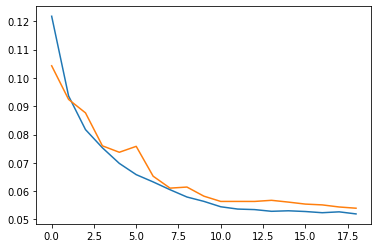

In [13]:
# Plot loss
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)
#plt.ylim([0, 0.05])
#plt.figure()
#plt.plot(learner.lr_history)

In [15]:
# Test model
test_filename_filter = partial(filename_filter, test=True)
    
test_ds = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=test_filename_filter, 
                                img_opener=img_opener_partial, label_opener=label_opener_partial, 
                                transforms=transform_funcs)

dataset.check_dataset()
test_dl = torch_dataloader.DataLoader(test_ds, batch_size=1, shuffle=False)

accs = learner.test(test_dl)
print(accs)

All images read
[0.5740496293228095, 0.7276334936801605, 0.6985839136809459, 0.7765455767143812]


In [16]:
# Show predictions
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_classes=True)


show(tensor_2_pil(yb.squeeze()), True)
show(tensor_2_pil(bin_pred), True)

NameError: name 'show' is not defined

## Example predictions

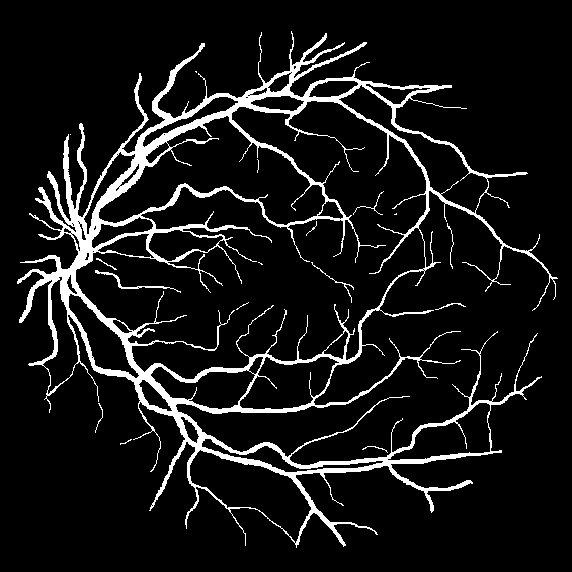

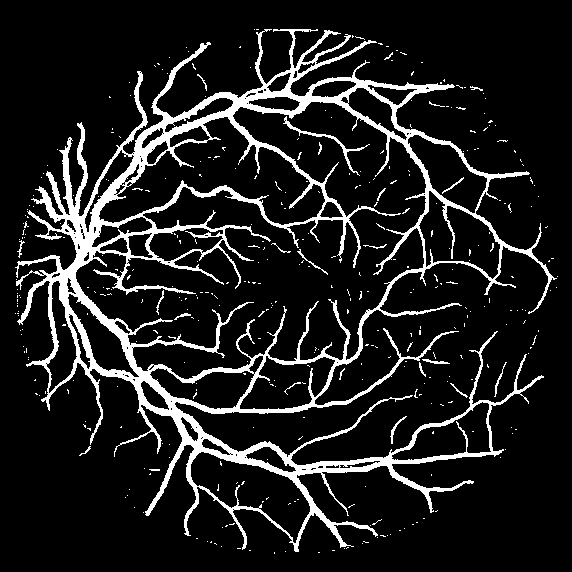

In [52]:
# For 
#'weight_dict':{'mask_thresh':0, #50,   
#               'back_weight':1, #15,
#               'vess_weitht':2, #25,
#               'small_vess_weight':255}
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_img=True)


show(tensor_2_pil(yb.squeeze()), True)
show(tensor_2_pil(bin_pred), True)

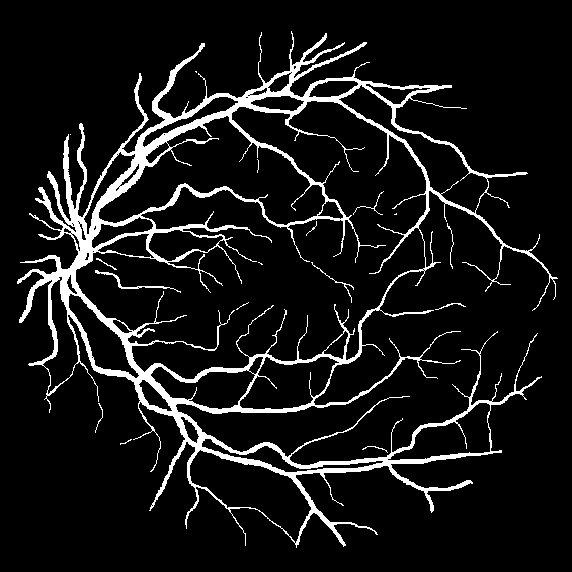

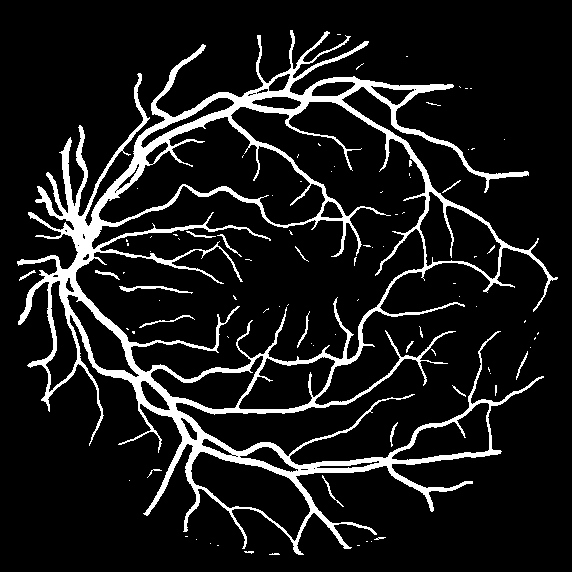

In [40]:
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_img=True)


show(tensor_2_pil(yb.squeeze()), True)
show(tensor_2_pil(bin_pred), True)

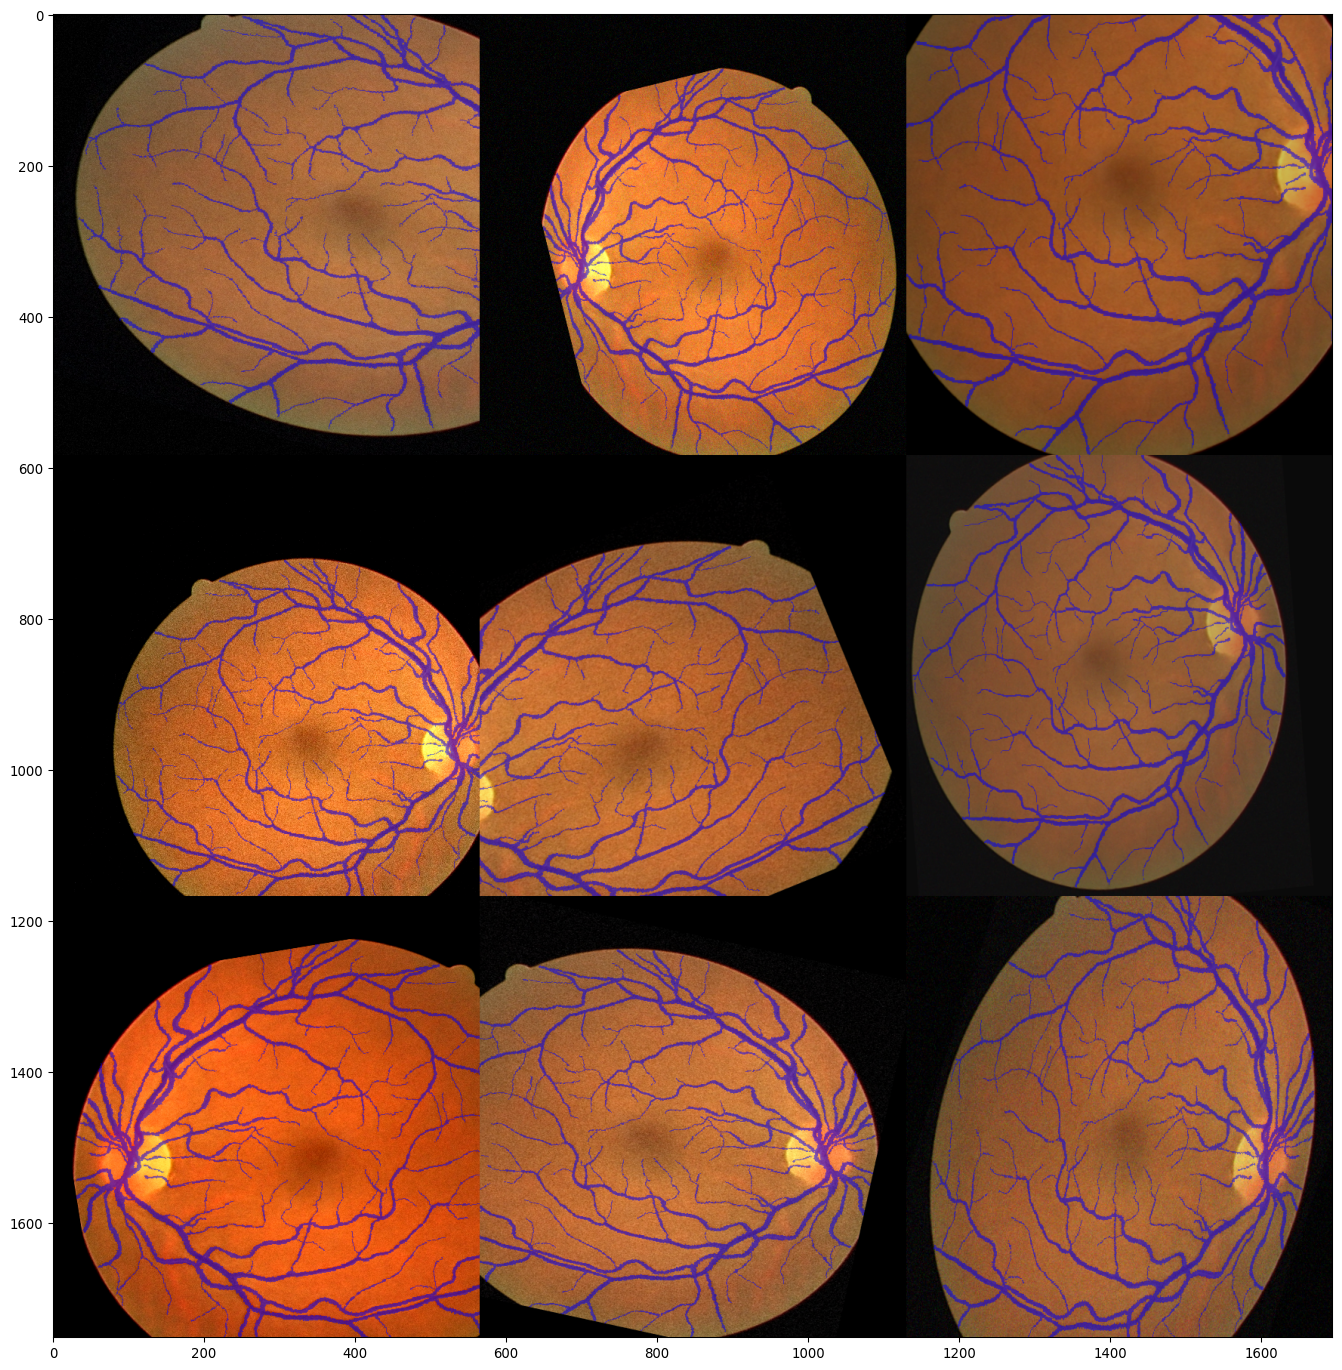

In [47]:
import numpy as np



ia.seed(1)

dataset = ImageDataset(img_dir, label_dir, name_2_label_map=name_2_label_map, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial)
img, seg = map(np.array, dataset[0])

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

segmap = ia.SegmentationMapsOnImage(seg, img.shape)
image_aug, segmap_aug = zip(*[seq(image=img, segmentation_maps=segmap) for _ in range(9)])
ia.show_grid([segmap_aug[i].draw_on_image(image_aug[i], colors=[[0,0,0],[0,0,255]], alpha=0.5)[0] for i in range(len(segmap_aug))])

# End

In [ ]:
#export perf_funcs.py

aaa = 10